# Importing Libraries


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from abc import ABC, abstractmethod
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LinearRegression



# Regression Classes


In [19]:
class RegressionModel(ABC):
    def __init__(self, alpha=0.001, tolerance=1e-6, epochs=1, batch_size=0, iterations=10000):
        self.alpha = alpha
        self.tolerance = tolerance
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = iterations
        self.coefficients = None

    # Abstract functions
    @abstractmethod
    def pred(self, W, X):
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def pred_drev(self, X):
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def loss(self, y, y_hat):
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def loss_drev(self, y, y_hat, X):
        raise NotImplementedError("Subclasses must implement this method")

    @abstractmethod
    def predict(self, X):
        raise NotImplementedError("Subclasses must implement this method")


    # Implemented functions
    def fit(self, X, y):
        self.coefficients = self.gradient_descent(X, y)

    def gradient_descent_helper(self, X, W, y):
        for i in range(self.epochs):
            for iter in range(self.iterations):

                y_hat = self.pred(W, X)
                new_W = W - self.loss_drev(y, y_hat, X) * self.alpha

                curr_loss = self.loss(y, y_hat)
                new_loss = self.loss(y, self.pred(new_W, X))
                if iter % 500 == 0:#print each 500 iteration
                    print(f"in the {iter} itereation \nthe loss is {curr_loss}\n\n")

                if abs(curr_loss - new_loss) <= self.tolerance:#convergence condition
                    print(f'Converged at iteration {iter}')
                    return new_W

                W = new_W #update weights

        return W

    def create_mini_batch(self, X, y):
        # Use instance variables directly
        m = X.shape[0] #number of rows
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        mini_batches = []
        for i in range(0, m, self.batch_size):
            X_batch = X_shuffled[i:i + self.batch_size] # new batch from i to i + batch size
            y_batch = y_shuffled[i:i + self.batch_size] # new batch from i to i + batch size
            mini_batches.append((X_batch, y_batch)) # add to all batchs
        return mini_batches

    def gradient_descent(self, X, y):
        #adjusting X and y shapes
        if self.batch_size == 0:self.batch_size = len(y)#defualt batch size is the whole data
        if (len(X.shape) == 1):X = X.reshape(-1, 1)
        if (len(y.shape) == 1):y = y.reshape(-1, 1)

        W = np.zeros(X.shape[1] + 1)
        if (len(W.shape) == 1):W = W.reshape(1, -1)

        X = np.c_[np.ones((X.shape[0], 1)), X]

        #applying mini batches
        mini_batches = self.create_mini_batch(X, y)
        for i, (X_batch, y_batch) in enumerate(mini_batches):#for each batch
            W = self.gradient_descent_helper(X_batch, W, y_batch)#calc optimal weights
            print(f"After {i} batch", W)

        return W

In [20]:
class myLinearRegression(RegressionModel):
    def predict(self, X):
        X = np.c_[np.ones((X.shape[0], 1)), X]  # Adding bias term
        return X @ self.coefficients.T

    def pred(self, W, X):
        return X @ W.T  # Linear prediction

    def pred_drev(self, X):
        return X  # Derivative of linear prediction with respect to X

    def loss(self, y, y_hat):
        return (1 / len(y)) * np.sum((y - y_hat) ** 2)  # Mean Squared Error

    def loss_drev(self, y, y_hat, X):
        return (-2 / len(y)) * (y - y_hat).T @ X  # Derivative of MSE with respect to weights


In [21]:
class myLogisticRegression(RegressionModel):
    def predict(self, X, threshold=0.5):
        X = np.c_[np.ones((X.shape[0], 1)), X]# add bais
        probabilities = self.pred(self.coefficients, X)#get proba
        return (probabilities >= threshold).astype(int)#apply thershold

    def pred(self, W, X):
        z = X @ W.T
        return 1 / (1 + np.exp(-z))#apply sigmoid σ(z)

    def pred_drev(self, X, W):
        z = X @ W.T
        sigmoid_output = 1 / (1 + np.exp(-z)) #σ(z)
        return sigmoid_output * (1 - sigmoid_output) * X #σ(z) * (1−σ(z)) * X

    def loss(self, y, y_hat):
        epsilon = 1e-15 #to avoid zero
        y_hat = np.clip(y_hat, epsilon, 1 - epsilon)#limt the values
        return -(1 / len(y)) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def loss_drev(self, y, y_hat, X):
        return (-1 / len(y)) *  (y - y_hat).T @ X


# Logistic Regression

In [22]:
X, y = make_classification(
    n_samples=100,
    n_features=1,
    n_informative=1,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = myLogisticRegression(iterations= 100000, batch_size = 10)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(report)


in the 0 itereation 
the loss is 0.6931471805599454


in the 500 itereation 
the loss is 0.6144001307576634


in the 1000 itereation 
the loss is 0.5496440994623323


in the 1500 itereation 
the loss is 0.4960442456436213


in the 2000 itereation 
the loss is 0.451298239583619


in the 2500 itereation 
the loss is 0.41359214629344276


in the 3000 itereation 
the loss is 0.3815164826030371


in the 3500 itereation 
the loss is 0.353980000918593


in the 4000 itereation 
the loss is 0.3301357579055906


in the 4500 itereation 
the loss is 0.3093225265399287


in the 5000 itereation 
the loss is 0.2910200693636471


in the 5500 itereation 
the loss is 0.2748155581918132


in the 6000 itereation 
the loss is 0.26037849961826276


in the 6500 itereation 
the loss is 0.24744199567629535


in the 7000 itereation 
the loss is 0.2357886766275498


in the 7500 itereation 
the loss is 0.22524007273499116


in the 8000 itereation 
the loss is 0.21564852387420338


in the 8500 itereation 
the loss

# Bulit-in Logistic Regression


In [24]:
X, y = make_classification(
    n_samples=100,
    n_features=1,
    n_informative=1,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print('Confusion Matrix:')
print(cm)
print('\nClassification Report:')
print(report)


Accuracy: 1.0000
Confusion Matrix:
[[12  0]
 [ 0  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



# Linear Regression

in the 0 itereation 
the loss is 558.7367124893652


in the 500 itereation 
the loss is 8.544211622521871


in the 1000 itereation 
the loss is 7.87603110194188


in the 1500 itereation 
the loss is 7.785434294306146


in the 2000 itereation 
the loss is 7.773150515744833


in the 2500 itereation 
the loss is 7.771484991101293


Converged at iteration 2511
After 0 batch [[-2.3435889   4.01800548]]
Mean Squared Error: 5.59118216258871
R-squared: 0.9896270721394822


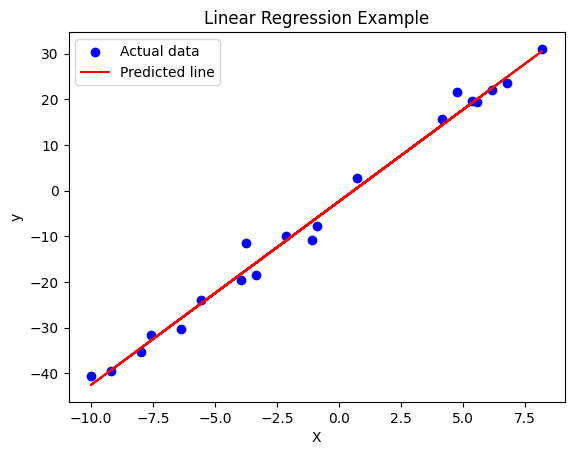

In [25]:
np.random.seed(42)

X = np.linspace(-10, 10, 100)
noise = np.random.normal(0, 3, size=X.shape)
y = 4 * X - 2 + noise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)




lr = myLinearRegression( batch_size = 0)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test.reshape(-1, 1), y_pred.reshape(-1, 1))

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.scatter(X_test, y_test, color='blue', label='Actual data')
X_test.reshape(1, -1)
plt.plot(X_test, y_pred.reshape(-1, 1), color='red', label='Predicted line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Example')
plt.legend()
plt.show()

#  Bulit-in Linear Regression

Mean Squared Error: 15.551056057254447
R-squared: 0.9720156716875056


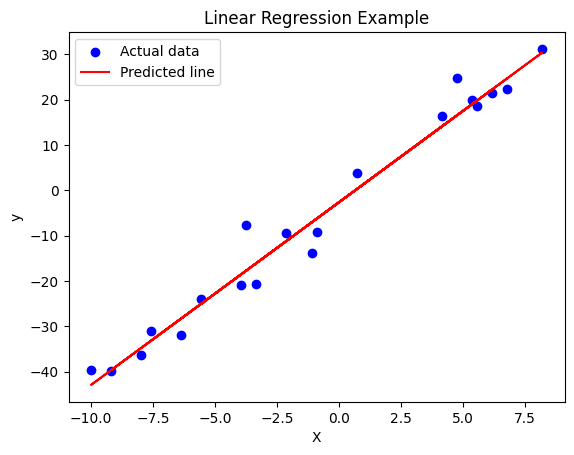

In [26]:
np.random.seed(42)
X = np.linspace(-10, 10, 100)
noise = np.random.normal(0, 5, size=X.shape)
y = 4 * X - 2 + noise

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

plt.scatter(X_test, y_test, color='blue', label='Actual data')
plt.plot(X_test, y_pred, color='red', label='Predicted line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression Example')
plt.legend()
plt.show()
